# Digit Recognizer
---

In [1]:
! pip install lightning -q

In [2]:
!pip uninstall tensorflow -y

Found existing installation: tensorflow 2.12.0
Uninstalling tensorflow-2.12.0:
  Successfully uninstalled tensorflow-2.12.0


In [3]:
import os

import lightning as L
import pandas as pd
import seaborn as sn
import torch
from IPython.display import display
from lightning.pytorch.loggers import CSVLogger
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchmetrics import Accuracy
from torchvision import transforms
from torchvision.datasets import MNIST

PATH_DATASETS = os.environ.get("PATH_DATASETS", ".")
print(PATH_DATASETS)
BATCH_SIZE = 256 if torch.cuda.is_available() else 64

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


.


## Simplest Example

In [4]:
class MNISTModel(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.l1 = torch.nn.Linear(28 * 28, 10)

    def forward(self, x):
        return torch.relu(self.l1(x.view(x.size(0), -1)))

    def training_step(self, batch, batch_nb):
        x, y = batch
        loss = F.cross_entropy(self(x), y)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.02)

By using the Trainer you automatically get: 
1. Tensorboard logging 
2. Model checkpointing 
3. Training and validation loop 
4. early-stopping

In [5]:
# Init our model
mnist_model = MNISTModel()

# Init DataLoader from MNIST Dataset
train_ds = MNIST(PATH_DATASETS, train=True, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE)

# Initialize a trainer
trainer = L.Trainer(
    accelerator="auto",
    devices=1,
    max_epochs=3,
)

# Train the model ⚡
trainer.fit(mnist_model, train_loader)

100%|██████████| 9912422/9912422 [00:00<00:00, 113776384.30it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 67635786.61it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 26825431.80it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 8024654.07it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
INFO: 
  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 7.9 K 
--------------------------------
7.9 K     Trainable params
0         Non-trainable params
7.9 K     Total params
0.031     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=3` reached.


## A more complete MNIST Lightning Module

In [6]:
class LitMNIST(L.LightningModule):
    def __init__(self, data_dir=PATH_DATASETS, hidden_size=64, learning_rate=2e-4):
        super().__init__()

        # Set our init args as class attributes
        self.data_dir = data_dir
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate

        # Hardcode some dataset specific attributes
        self.num_classes = 10
        self.dims = (1, 28, 28)
        channels, width, height = self.dims
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
            ]
        )

        # Define PyTorch model
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(channels * width * height, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, self.num_classes),
        )

        self.val_accuracy = Accuracy(task="multiclass", num_classes=10)
        self.test_accuracy = Accuracy(task="multiclass", num_classes=10)

    def forward(self, x):
        x = self.model(x)
        return F.log_softmax(x, dim=1)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.val_accuracy.update(preds, y)

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", self.val_accuracy, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.test_accuracy.update(preds, y)

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", self.test_accuracy, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    ####################
    # DATA RELATED HOOKS
    ####################

    def prepare_data(self):
        # download
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        # Assign train/val datasets for use in dataloaders
        if stage == "fit" or stage is None:
            mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

        # Assign test dataset for use in dataloader(s)
        if stage == "test" or stage is None:
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=BATCH_SIZE)

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=BATCH_SIZE)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=BATCH_SIZE)

In [7]:
model = LitMNIST()
trainer = L.Trainer(
    accelerator="auto",
    devices=1,
    max_epochs=3,
    logger=CSVLogger(save_dir="logs/"),
)
trainer.fit(model)

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
INFO: 
  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | Sequential         | 55.1 K
1 | val_accuracy  | MulticlassAccuracy | 0     
2 | test_accuracy | MulticlassAccuracy | 0     
-----------------------------------------------------
55.1 K    Trainable params
0         Non-trainable params
55.1 K    Total params
0.220     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=3` reached.


In [8]:
trainer.test()

/opt/conda/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
INFO: Restoring states from the checkpoint path at logs/lightning_logs/version_0/checkpoints/epoch=2-step=645.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
INFO: Loaded model weights from the checkpoint at logs/lightning_logs/version_0/checkpoints/epoch=2-step=645.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9261000156402588     │
│         test_loss         │    0.25436073541641235    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.25436073541641235, 'test_acc': 0.9261000156402588}]

,val_loss,val_acc,test_loss,test_acc
epoch,,,,
0,0.438489,0.8848,NaN,NaN
1,0.322505,0.9072,NaN,NaN
2,0.279106,0.9156,NaN,NaN
3,NaN,NaN,0.254361,0.9261


/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


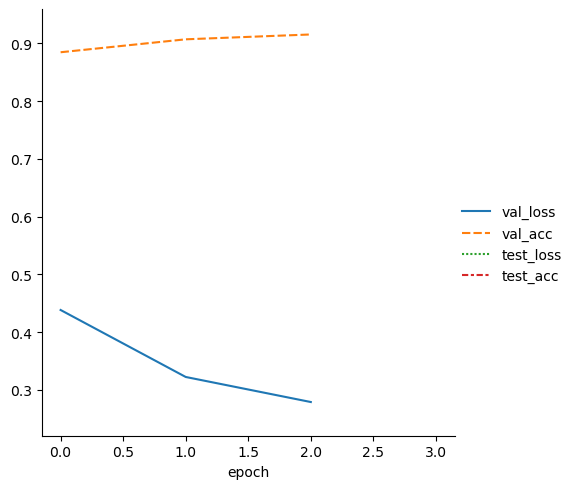

In [9]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
display(metrics.dropna(axis=1, how="all").head())
sn.relplot(data=metrics, kind="line")

In [10]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor

## Load Data
---

In [11]:
train_data = datasets.MNIST(root="data",train=True,transform=ToTensor(),download=True)
test_data = datasets.MNIST(root="data",train=False,transform=ToTensor(),download=True)

print("\nTrain Data\n----------\n",train_data)
print("\nTest Data\n----------\n",test_data)

100%|██████████| 9912422/9912422 [00:00<00:00, 100361152.13it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 63957599.70it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 31275653.34it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 8065422.85it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw


Train Data
----------
 Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

Test Data
----------
 Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [12]:
print("Train Data Shape : ",train_data.data.shape)
print("Test Data Shape : ",test_data.data.shape)

Train Data Shape :  torch.Size([60000, 28, 28])
Test Data Shape :  torch.Size([10000, 28, 28])


* The shape of the data indicates that the images has no color channels as the shape is `[batch, height, width]` & not `[batch, height, width, channel]`.

## DataLoader
---

In [13]:
from torch.utils.data import DataLoader

In [14]:
train_data_loader = DataLoader(dataset=train_data,batch_size=64,shuffle=True, num_workers=2)
test_data_loader = DataLoader(dataset=test_data,batch_size=64,shuffle=True, num_workers=2)

## Model
---

In [15]:
! pip install lightning -q
! pip uninstall tensorflow -y -q

In [16]:
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import lightning.pytorch as pl

In [17]:
class CNN(pl.LightningModule):
    
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(in_features=320, out_features=50)
        self.fc2 = nn.Linear(in_features=50, out_features=10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = torch.max_pool2d(x, 2)
        x = self.conv2(x)
        x = torch.relu(x)
        x = torch.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        return x
        
    def training_step(self, batch, batch_idx):
        x, y = batch
        output = self(x)
        loss = nn.functional.cross_entropy(output, y)
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        output = self(x)
        loss = nn.functional.cross_entropy(output, y)
        self.log('val_loss', loss)
        return loss
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        output = self(x)
        loss = nn.functional.cross_entropy(output, y)
        self.log('test_loss', loss)
        _, predicted = torch.max(output, 1)
        accuracy = torch.sum(predicted == y.data).item() / y.size(0)
        self.log('test_accuracy', accuracy, prog_bar=True)
    
    def predict_step(self, batch, batch_idx, dataloader_idx=None):
        x, _ = batch
        output = self(x)
        _, predicted = torch.max(output, 1)
        return predicted
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=0.001)
        return optimizer

# Assuming you have training and validation dataloaders
train_loader = train_data_loader
val_loader = test_data_loader

model = CNN()

trainer = pl.Trainer(max_epochs=1)
trainer.fit(model, train_loader, val_loader)


INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:65                                                                                   │
│                                                                                                  │
│   62 model = CNN()                                                                               │
│   63                                                                                             │
│   64 trainer = pl.Trainer(max_epochs=1)                                                          │
│ ❱ 65 trainer.fit(model, train_loader, val_loader)                                                │
│   66                                                                                             │
│                                                                                                  │
│ /opt/conda/lib/python3.10/site-packages/lightning/pytorch/trainer/trainer.py:532 in fit          │
│                                                                                                  │
│    529 │   │   model = _maybe_unwrap_optimized(model)                                            │
│    530 │   │   self.strategy._lightning_module = model                                           │
│    531 │   │   _verify_strategy_supports_compile(model, self.strategy)                           │
│ ❱  532 │   │   call._call_and_handle_interrupt(                                                  │
│    533 │   │   │   self, self._fit_impl, model, train_dataloaders, val_dataloaders, datamodule,  │
│    534 │   │   )                                                                                 │
│    535                                                                                           │
│                                                                                                  │
│ /opt/conda/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:42 in                  │
│ _call_and_handle_interrupt                                                                       │
│                                                                                                  │
│    39 │   """                                                                                    │
│    40 │   try:                                                                                   │
│    41 │   │   if trainer.strategy.launcher is not None:                                          │
│ ❱  42 │   │   │   return trainer.strategy.launcher.launch(trainer_fn, *args, trainer=trainer,    │
│    43 │   │   return trainer_fn(*args, **kwargs)                                                 │
│    44 │                                                                                          │
│    45 │   except _TunerExitException:                                                            │
│                                                                                                  │
│ /opt/conda/lib/python3.10/site-packages/lightning/pytorch/strategies/launchers/multiprocessing.p │
│ y:101 in launch                                                                                  │
│                                                                                                  │
│    98 │   │   """                                                                                │
│    99 │   │   self._check_torchdistx_support()                                                   │
│   100 │   │   if self._start_method in ("fork", "forkserver"):                                   │
│ ❱ 101 │   │   │   _check_bad_cuda_fork()                                                         │
│   102 │   │                                                                                      │
│   103 │   │   # The default cluster environment in Lightning chooses a random free port number   │
│   104 │   │   # This needs to be done in the main process h

In [ ]:
trainer